In [1]:
import os 
os.chdir(r'Q:\sachuriga\Sachuriga_Python/quattrocolo-nwb4fp\src')

from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap,plot_path
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,unit_location_ch
from scipy.ndimage import gaussian_filter
import ast
import pandas as pd
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd


Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\examples\tracking_plot.py:5: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
import pandas as pd
df_loaded = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/all_units_table.pkl')
len(df_loaded)
df_good = df_loaded[df_loaded['unit_quality']=="good"]
df_good.head()

spike_times unit_name  sd_ratio  \
0  [53.421866666666666, 54.1465, 61.9342333333333...        41  1.665216   
1  [52.239733333333334, 52.245, 52.2489, 53.17986...        47  2.558734   
2  [49.5235, 49.52916666666667, 49.5744, 49.58223...        60  1.512081   
3  [49.632333333333335, 49.638466666666666, 49.65...         1  1.594608   
5  [49.5356, 49.56426666666667, 49.57673333333334...         4  0.978401   

   sync_spike_8.1  presence_ratio  cluster_id.30  half_width     l_ratio.1  \
0             0.0         0.97561            0.0    0.000103  4.376648e-05   
1             0.0         1.00000            1.0    0.000143  9.769963e-18   
2             0.0         1.00000            2.0    0.000123  0.000000e+00   
3             0.0         1.00000            3.0    0.000210  2.043745e-03   
5             0.0         1.00000            5.0    0.000133  1.016816e-02   

   recovery_slope.1  cluster_id.19  ... animal_id  \
0    -208751.824563            0.0  ...     66922   
1    -180256.638141            1.0  ...     66922   
2    -150731.936891            2.0  ...     66922   
3     -49075.422890            3.0  ...     66922   
5     -89132.779959            5.0  ...     66922   

                                     session_id                 cell_type  \
0  66922_2024-09-25_15-39-48_A_phy_k_manual.nwb           Pyramidal cells   
1  66922_2024-09-25_15-39-48_A_phy_k_manual.nwb           Pyramidal cells   
2  66922_2024-09-25_15-39-48_A_phy_k_manual.nwb  Narrow spike interneuron   
3  66922_2024-09-25_15-39-48_A_phy_k_manual.nwb   Wide Spike Interneurons   
5  66922_2024-09-25_15-39-48_A_phy_k_manual.nwb  Narrow spike interneuron   

   functional_cell_type                    genotype              experimenter  \
0            Place cell  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   
1             normal_py  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   
2            Speed cell  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   
3            Speed cell  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   
5            Speed cell  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   

   sex  cell_type_group_6_group  cell_type_group_2_group  session  
0    F                        1                        1        A  
1    F                        1                        1        A  
2    F                        3                        3        A  
3    F                        5                        3        A  
5    F                        3                        3        A  

[5 rows x 134 columns]

In [47]:
metrics = ['half_width', 'recovery_slope', 'repolarization_slope', 
        'firing_range', 'peak_trough_ratio', 'peak_to_valley','matlab_acg_tau_rise','cell_type_group_2_group']
cls =  ['half_width', 'recovery_slope', 'repolarization_slope', 
        'firing_range', 'peak_trough_ratio', 'peak_to_valley','matlab_acg_tau_rise','cell_type_group_2_group']
df_good = df_good[metrics].dropna()

In [48]:
import pandas as pd
import numpy as np



# Function to remove outliers using IQR method
def remove_outliers(df, columns, factor=1.5):
    df_clean = df.copy()
    for col in columns:
        if df[col].dtype in [np.float64, np.int64]:  # Only process numeric columns
            Q1 = df[col].quantile(0.25)  # First quartile
            Q3 = df[col].quantile(0.75)  # Third quartile
            IQR = Q3 - Q1  # Interquartile range
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            # Filter out rows where the value is outside the bounds
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Assuming df_good is your original DataFrame
# Remove outliers from numeric columns in metrics
numeric_metrics = [col for col in metrics if df_good[col].dtype in [np.float64, np.int64]]
df_no_outliers = remove_outliers(df_good, numeric_metrics)

# Select only the specified columns and drop any remaining NaN values
df_lda = df_no_outliers[metrics].dropna()

# Optional: Check the shape of the resulting DataFrame
print(f"Original shape: {df_good.shape}")
print(f"Shape after removing outliers and NaN: {df_lda.shape}")

Original shape: (1637, 8)
Shape after removing outliers and NaN: (1222, 8)


In [49]:
df_lda 

half_width  recovery_slope  repolarization_slope  firing_range  \
0       0.000103  -208751.824563          1.418055e+06          1.58   
6       0.000167   -56801.713285          1.188074e+06         17.00   
7       0.000150  -135962.519359          2.481065e+06         16.94   
8       0.000147  -129463.068263          1.452573e+06          5.98   
9       0.000167  -149586.994735          1.236903e+06          5.40   
10      0.000253  -114170.036023          1.105141e+06          3.80   
15      0.000183   -90892.336866          8.086632e+05         13.58   
16      0.000123   -99180.494619          1.393311e+06         12.58   
20      0.000120   -83644.962798          3.042713e+06          9.18   
21      0.000100  -127287.980146          1.128948e+06          6.60   
23      0.000133   -98258.753371          7.993655e+05          1.80   
27      0.000110  -230661.448456          1.482886e+06          1.20   
31      0.000107  -192171.610684          1.771888e+06          4.20   
32      0.000190   -53824.647225          6.411457e+05          5.58   
33      0.000140   -82688.620305          7.434379e+05          5.00   
34      0.000193   -77063.483080          4.264395e+05          5.20   
35      0.000127  -154762.839388          1.229776e+06          7.00   
37      0.000193  -135012.562402          1.030825e+06          2.80   
38      0.000103  -151900.470747          5.186047e+05          9.76   
39      0.000113  -110412.581312          7.260929e+05          4.60   
40      0.000080   -58727.597060          9.793032e+04          3.58   
41      0.000133  -156831.938611          1.777892e+06          2.60   
42      0.000113  -135826.081350          8.644386e+05          0.80   
43      0.000097  -189691.323121          2.558203e+06          0.20   
44      0.000143  -130640.317634          1.347201e+06          2.20   
45      0.000177   -43784.124843          8.309498e+05          3.60   
46      0.000150  -114143.425971          9.397660e+05          5.04   
47      0.000173  -140717.915608          1.097191e+06          1.60   
48      0.000213   -79880.002512          8.981189e+05          1.62   
50      0.000127  -106073.755624          2.039317e+06          2.64   
51      0.000150  -102996.551247          1.213249e+06          4.04   
52      0.000107  -108849.737916          8.872785e+05          7.42   
53      0.000120  -121091.336291          5.244555e+05          7.24   
55      0.000103  -141799.207406          1.972819e+06          1.60   
56      0.000127   -78118.659925          9.969519e+05          2.22   
59      0.000113   -84398.764292          3.011508e+06         20.06   
61      0.000167   -41703.661563          6.823461e+05          9.66   
62      0.000173  -108480.483263          6.076005e+05          6.02   
63      0.000140  -102456.294835          8.785729e+05          9.04   
64      0.000113  -101396.674573          3.314920e+06         27.22   
65      0.000193   -64344.172966          6.149178e+05         10.82   
67      0.000123   -60810.170588          4.635472e+05          5.62   
68      0.000143   -61397.657052          1.584739e+06         13.60   
69      0.000147  -143401.404331          1.707362e+06          3.50   
70      0.000160  -100188.110058          2.607754e+06          1.60   
71      0.000220   -56566.036972          5.263078e+05         14.22   
72      0.000203  -100647.743482          8.182323e+05          4.80   
75      0.000150   -90479.573580          6.074536e+05         12.04   
77      0.000173   -57375.336881          9.465610e+05         14.46   
78      0.000147  -105850.079169          1.196745e+06          1.60   
79      0.000157  -115689.048742          9.021327e+05          1.40   
80      0.000140  -226485.777514          2.397634e+06          0.60   
82      0.000127   -65270.201889          2.053941e+06         27.25   
83      0.000233   -74902.154468          6.130330e+05          7.20   
86      0.000160  -108014.852474          1.16

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [51]:
dataset=df_lda
# Divide the data set into features (X) and target variable (y)
X = dataset.iloc[:, 0:7].values
y = dataset.iloc[:, 7].values

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

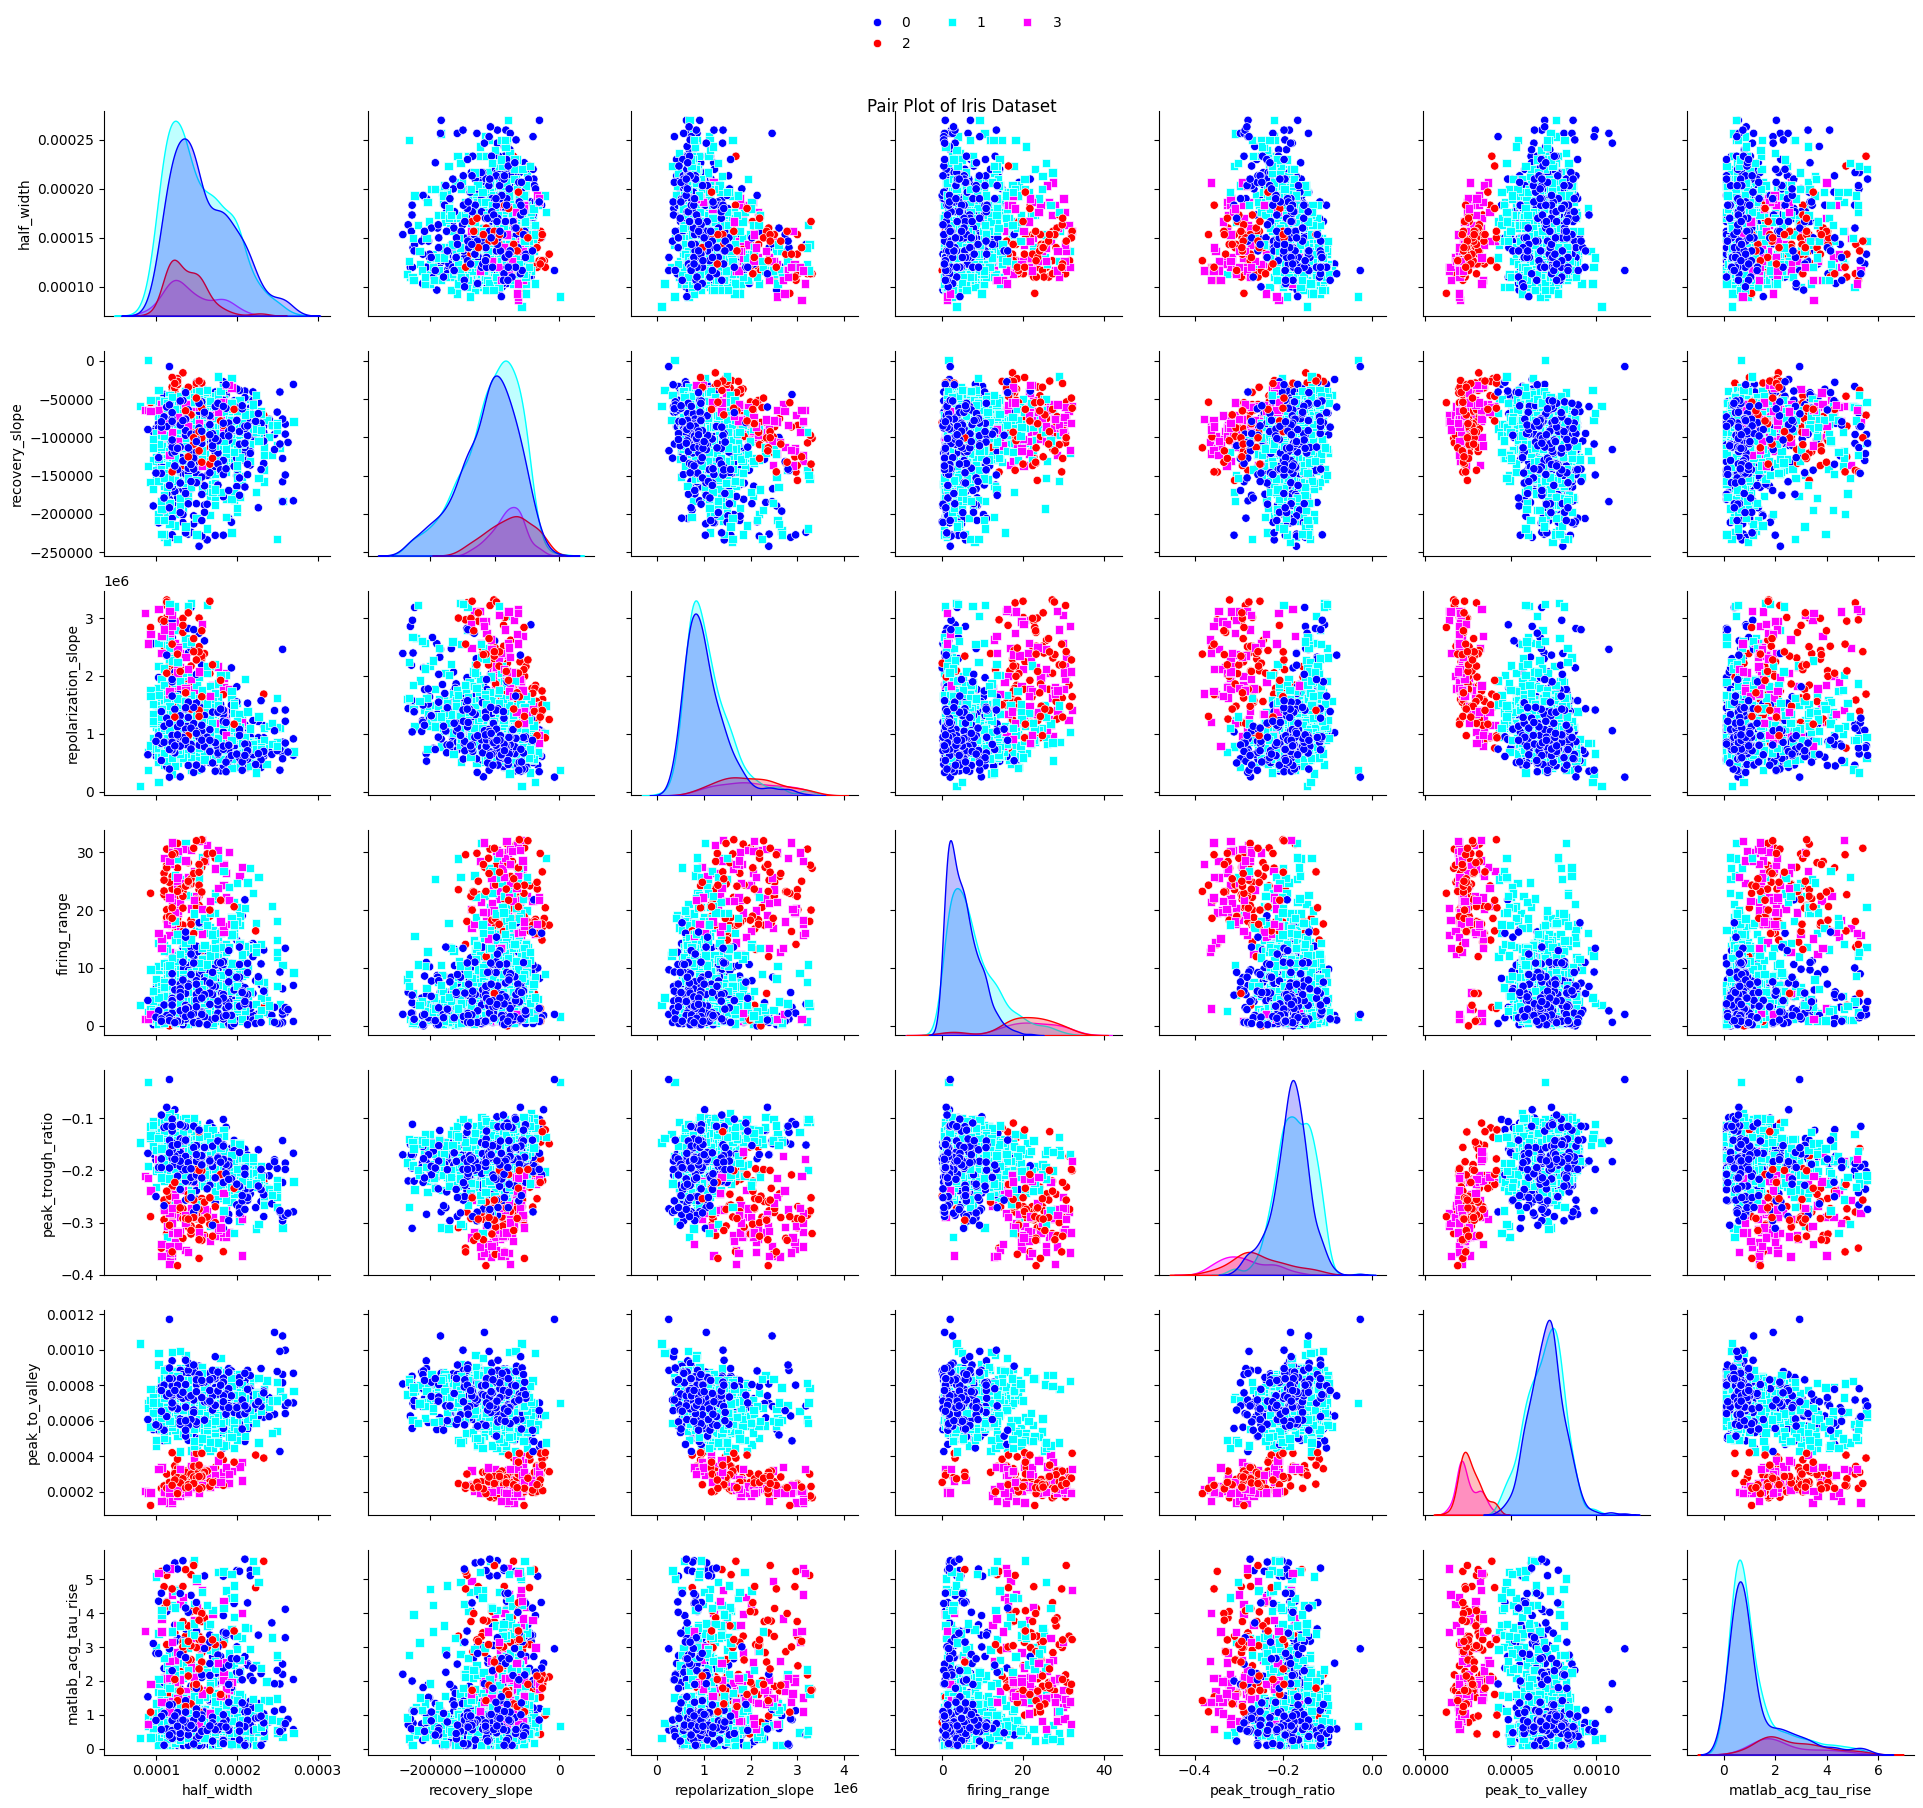

In [52]:
# Create a pair plot to visualize relationships between different features and species.
ax = sns.pairplot(dataset, hue='cell_type_group_2_group', markers=["o", "s","o", "s"], palette=["blue","red", "cyan", "magenta"],hue_order=[0,2,1,3])
plt.suptitle("Pair Plot of Iris Dataset")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.tight_layout()
plt.show()

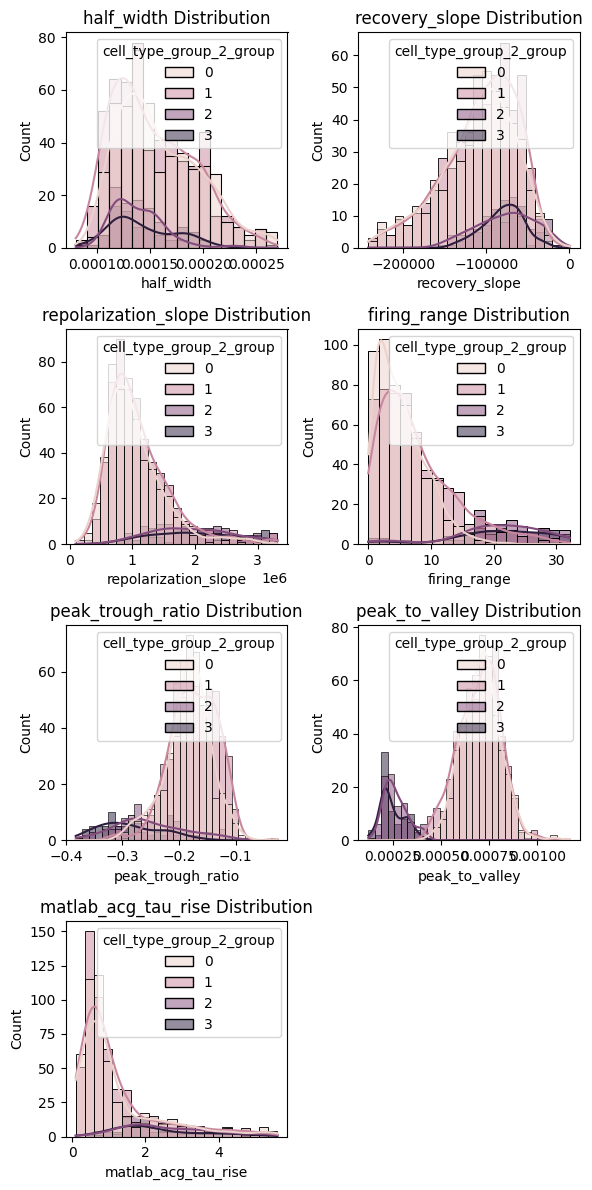

In [55]:
# Visualize the distribution of each feature using histograms.
plt.figure(figsize=(6, 12))
for i, feature in enumerate(cls[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.histplot(data=dataset, x=feature, hue='cell_type_group_2_group', kde=True)
    plt.title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

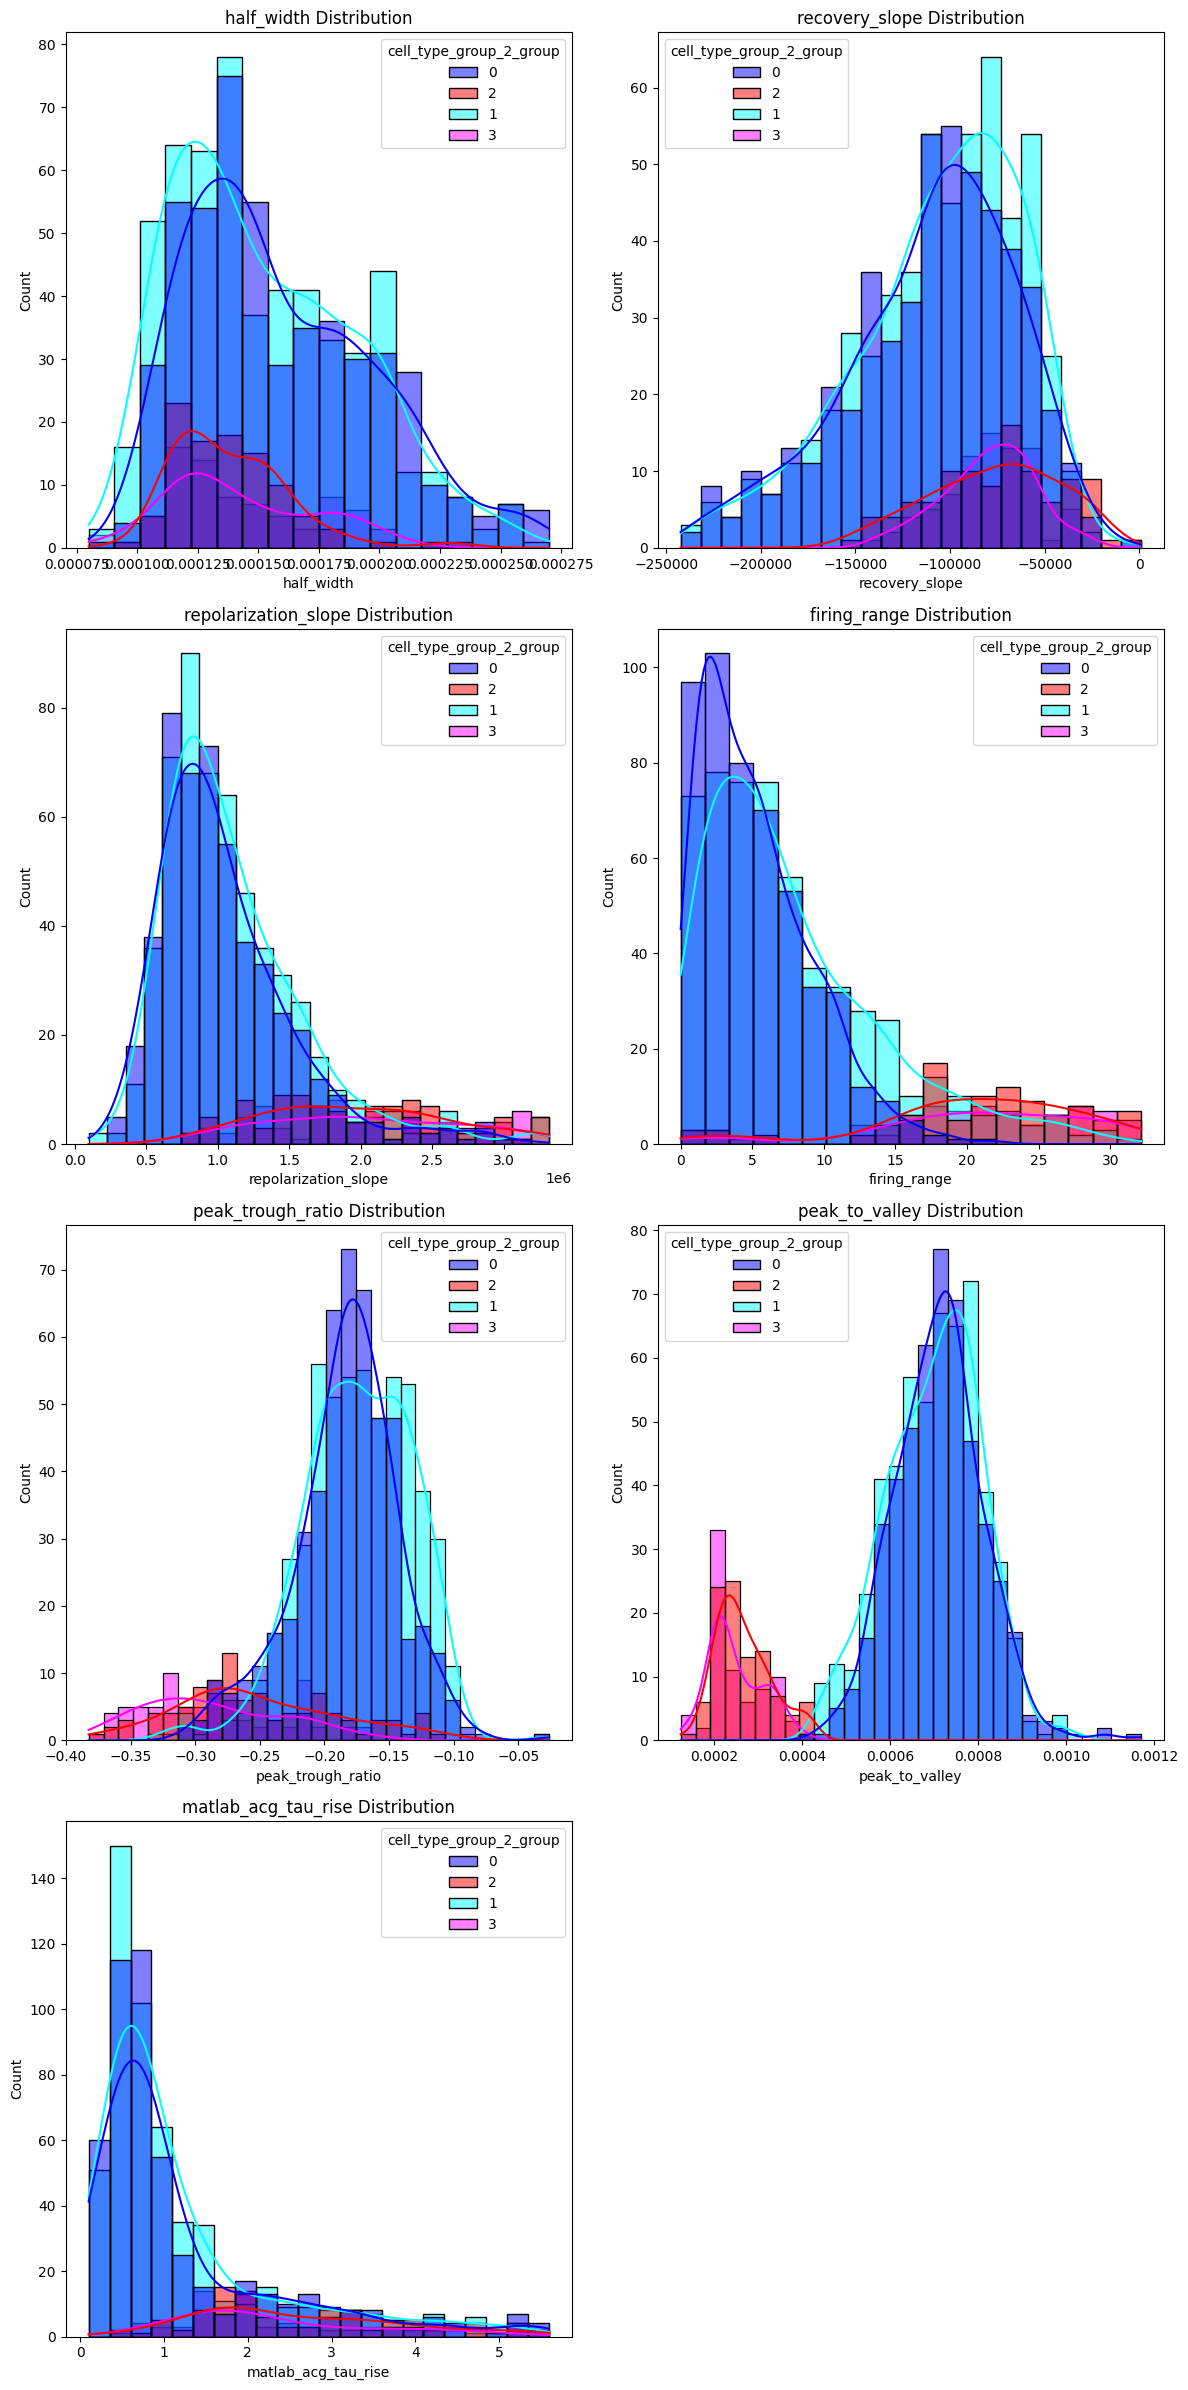

In [66]:
# Define custom colors for the 4 groups (you can adjust these hex codes as needed)
colors =["blue","red", "cyan", "magenta"] # Blue, Orange, Green, Red

plt.figure(figsize=(12, 24))
for i, feature in enumerate(cls[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.histplot(
        data=dataset, 
        x=feature, 
        hue='cell_type_group_2_group',
        hue_order=[0, 2, 1, 3],  # Your specified hue order
        palette=colors,         # Applying the custom colors
        kde=True
    )
    plt.title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

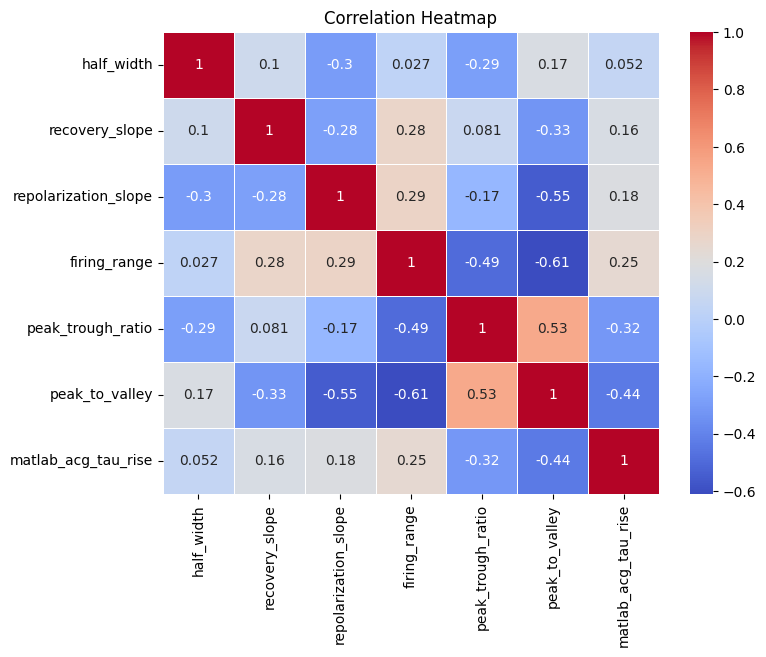

In [56]:
correlation_matrix = dataset.corr(numeric_only = True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [57]:
# Split the data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
# Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

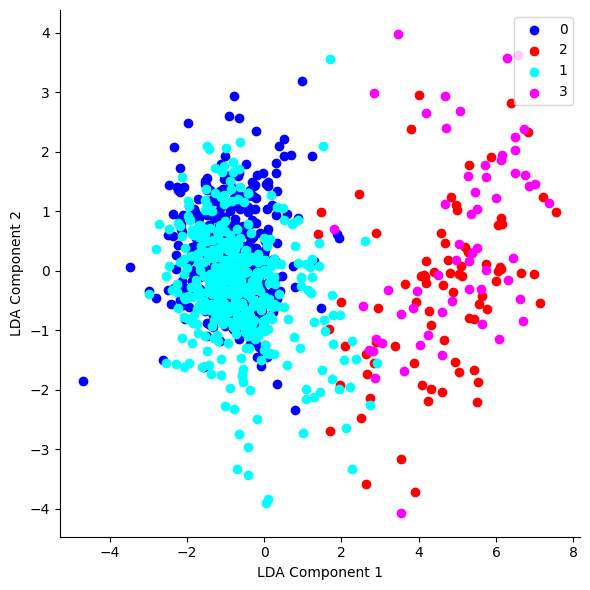

In [ ]:
tmp_Df = pd.DataFrame(X_train, columns=['LDA Component 1','LDA Component 2'])
tmp_Df['cell_type_group_2_group']=y_train

sns.FacetGrid(tmp_Df, hue ='cell_type_group_2_group',
              height = 6, hue_order=[0, 2, 1, 3],palette=colors).map(plt.scatter,
                              'LDA Component 1',
                              'LDA Component 2')

plt.legend(loc='upper right')

In [68]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Accuracy: 0.58


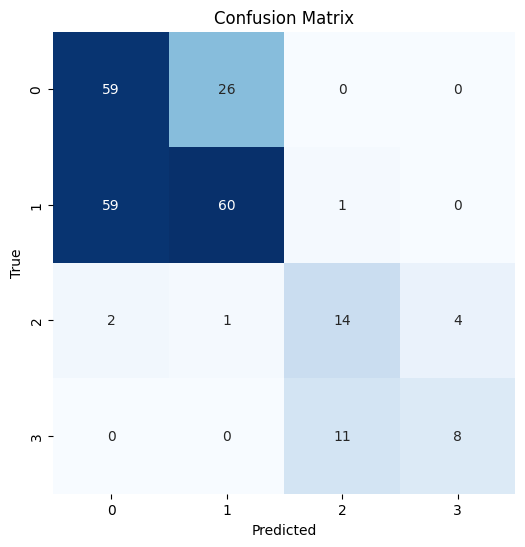

In [69]:
#Assume 'y_test' and 'y_pred' are already defined
accuracy = accuracy_score(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)

#Display the accuracy
print(f'Accuracy: {accuracy:.2f}')

#Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()